# The Relationship Between Host Experience and Ratings In LA | Hypothesis Testing

# Step 0: My Goal

**Research Question**: Do more experienced hosts recieve higher ratings?

**Null Hypothesis**: There is no monotonic relationship between host tenure and ratings.

**Alternative Hypothesis**: There is a positive monotonic relationship between host tenure and ratings.

# Step 1: Getting my data

I'm going to use Airbnb data from the city of Los Angeles for this project.

In [194]:
# For data handling
import pandas as pd   
import numpy as np

# For visualization 
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical testing
from scipy import stats
from scipy.stats import spearmanr  
import statsmodels.api as sm
import statsmodels.formula.api as smf

df = pd.read_csv(
    'CSV_Files/listings.csv',
    engine='python',     
    on_bad_lines='skip',  
    quotechar='"'         
)
df = df[pd.to_numeric(df['id'], errors='coerce').notnull()]
df.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2708,https://www.airbnb.com/rooms/2708,20250617032927,2025-06-17,city scrape,"Run Runyon, Beaut Furn Mirror Mini-Suit w/ Fir...",Run Runyon Canyon<br /><br />Gym & Sauna <br /...,"Walk and run to Runyon Canyon, it is open!<br ...",https://a0.muscache.com/pictures/hosting/Hosti...,3008,...,4.98,4.95,4.86,NaN,t,2,0,2,0,0.33
1,2732,https://www.airbnb.com/rooms/2732,20250617032927,2025-06-17,city scrape,Zen Life at the Beach,An oasis of tranquility awaits you.,"This is the best part of Santa Monica. Quiet, ...",https://a0.muscache.com/pictures/1082993/c5a99...,3041,...,4.48,4.91,4.22,228269,f,2,1,1,0,0.14
2,2864,https://www.airbnb.com/rooms/2864,20250617032927,2025-06-17,previous scrape,* Beautiful Master Suite/Jacuzzi Tub/*,Centrally located.... Furnished with King Size...,What makes the neighborhood unique is that the...,https://a0.muscache.com/pictures/23817858/de20...,3207,...,NaN,NaN,NaN,NaN,f,1,1,0,0,NaN
3,6033,https://www.airbnb.com/rooms/6033,20250617032927,2025-06-17,previous scrape,Poolside Serenity Studio,Our distinctive bachelor's studio for 1-3 gues...,NaN,https://a0.muscache.com/pictures/458111/986c76...,11619,...,4.35,4.65,4.29,NaN,f,6,3,3,0,0.10
4,6931,https://www.airbnb.com/rooms/6931,20250617032927,2025-06-17,city scrape,"RUN Runyon, Beau Furn Rms Terrace Hollyw Hill ...",Run Runyon Canyon & Views<br /><br />Gym & Sau...,We are in the middle of one of the great citie...,https://a0.muscache.com/pictures/miso/Hosting-...,3008,...,4.91,4.71,4.76,NaN,t,2,0,2,0,0.19


# Step 2: Clean Data

In [195]:
# Figuring out which columns have missing values.
df.isnull().sum()

id                                                0
listing_url                                       0
scrape_id                                         0
last_scraped                                      0
source                                            0
                                               ... 
calculated_host_listings_count                    0
calculated_host_listings_count_entire_homes       0
calculated_host_listings_count_private_rooms      0
calculated_host_listings_count_shared_rooms       0
reviews_per_month                               219
Length: 79, dtype: int64

**Fixing data types**:

In [196]:
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)

# Making sure dates are stored as dates in case they're stored as strings.
df['host_since'] = pd.to_datetime(df['host_since'], errors='coerce') # Always put errors='coerce' if unsure about data quality.
df['last_scraped'] = pd.to_datetime(df['last_scraped'], errors='coerce') 
df['calendar_last_scraped'] = pd.to_datetime(df['calendar_last_scraped'], errors='coerce') 
df['first_review'] = pd.to_datetime(df['first_review'], errors='coerce') 
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce') 

# Cleaning text.
text_cols = df.select_dtypes(include='object').columns 
def clean_text(text):
    if isinstance(text, str):
        text = text.replace("<br>", "") # These are common HTML tags that I want to remove.
        text = text.replace("<br />", "")
        text = text.replace("<p>", "")
        text = text.replace("</p>", "")
        text = text.strip() # Removing blank spaces.
    return text

for col in text_cols: # Applying the function to the whichever columns have text.
    df[col] = df[col].apply(clean_text)

**Normalizing categorical data**:

In [197]:
categorical_cols = [i for i in text_cols if df[i].nunique() < 50] # If a column has a small number of unique values (< 50), it’s probably categorical.
def clean_categorical(data):
    if isinstance(data, str):
        cleaned = data.strip().lower()
        
        # Fixing abbreviations 
        if cleaned == "t" or cleaned == "true":
            return "True" # If I used a boolean, it would make the data messy. I don't want to mix booleans and strings.
        elif cleaned == "f" or cleaned == "false":
            return "False"
        return cleaned
        
    return data # Leave numbers/NaN unchanged.

for cat in categorical_cols: # Applying the function to the whichever columns have text.
    df[cat] = df[cat].apply(clean_categorical)

**Handle outliers and inconsistent data**:

In [198]:
numerical_cols = df.select_dtypes(include='number').columns 
def clean_numerical(numbers, colname):
    if isinstance(numbers, (int, float)):
        if numbers < 0:
            return np.nan
    if colname == "review_scores_value" and numbers < 0 or numbers > 5:
        return np.nan
    return numbers

for num in numerical_cols:
    df[num] = df[num].apply(lambda x: clean_numerical(x, num))

# Step 3: Feature Engineering

In [199]:
# Host Tenure; Difference between today’s date and the host_since date for each host.
df['host_tenure'] = (pd.Timestamp("today") - df['host_since']).dt.days / 365 # Host tenure is measured in years.
# I just need host tenure for this project.

# Step 4: Exploratory Data Analysis 

**4.1: Basic sanity checks**

In [200]:
df.info() # Confirming that host_since is datetime64 and review_scores_value is float64.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2118 entries, 0 to 2117
Data columns (total 80 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            0 non-null      float64       
 1   listing_url                                   2118 non-null   object        
 2   scrape_id                                     0 non-null      float64       
 3   last_scraped                                  2118 non-null   datetime64[ns]
 4   source                                        2118 non-null   object        
 5   name                                          2118 non-null   object        
 6   description                                   2023 non-null   object        
 7   neighborhood_overview                         1661 non-null   object        
 8   picture_url                                   2118 non-null   object

In [201]:
df[['host_tenure', 'review_scores_value']].describe() # Checking mean, min, max, etc.

,host_tenure,review_scores_value
count,2118.000000,1898.000000
mean,12.439366,4.737993
std,1.469148,0.285250
min,0.547945,0.000000
25%,11.342466,4.660000
50%,12.234247,4.790000
75%,13.323288,4.890000
max,17.005479,5.000000


**4.2: Distributions**

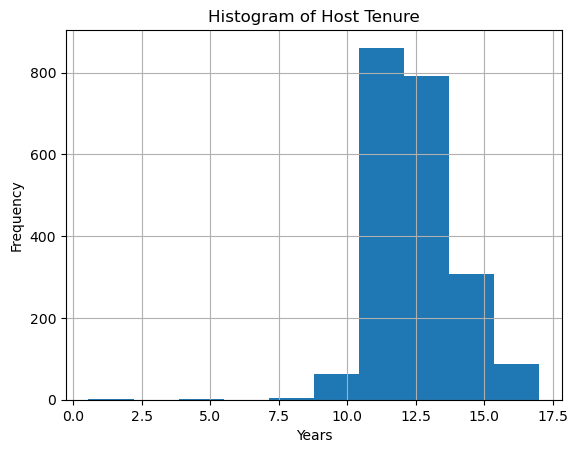

In [202]:
df['host_tenure'].hist()
plt.title('Histogram of Host Tenure') 
plt.xlabel('Years') 
plt.ylabel('Frequency')
plt.show() 

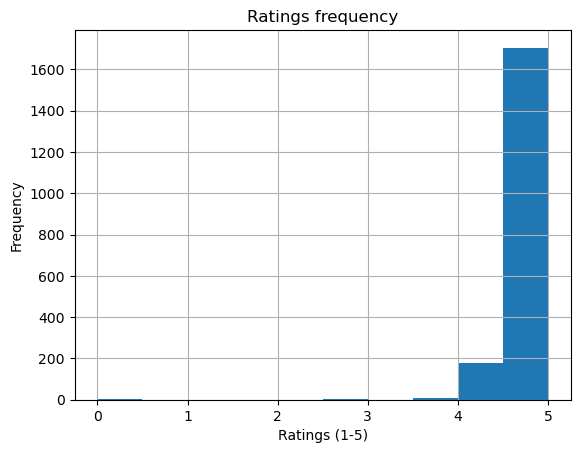

In [203]:
df['review_scores_value'].hist()
plt.title('Ratings frequency') 
plt.xlabel('Ratings (1-5)') 
plt.ylabel('Frequency')
plt.show() 

**4.3: Binning**

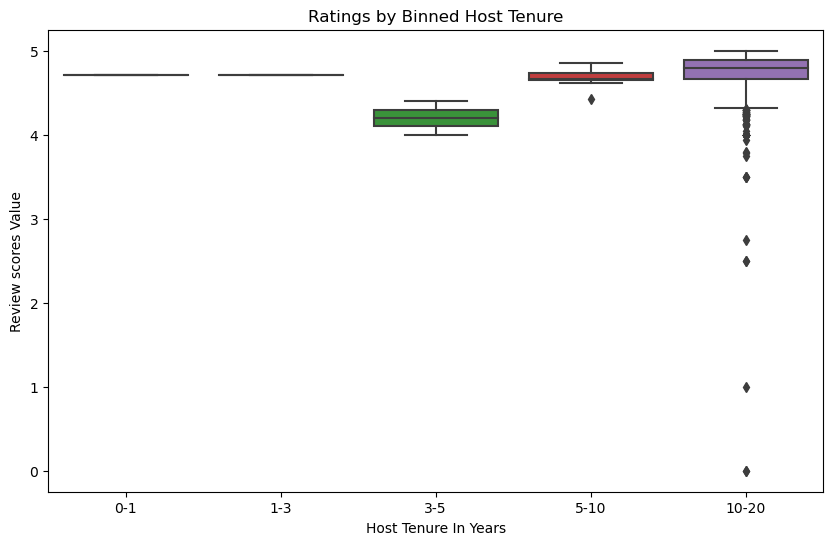

In [204]:
# Creating bins
bins = [0, 1, 3, 5, 10, 20] # Years.
labels = ['0-1', '1-3', '3-5', '5-10', '10-20']
df['tenure_bin'] = pd.cut(df['host_tenure'], bins=bins, labels=labels)

plt.figure(figsize=(10,6))
sns.boxplot(x='tenure_bin', y='review_scores_value', data=df)
plt.xlabel('Host Tenure In Years')
plt.ylabel('Review scores Value')
plt.title('Ratings by Binned Host Tenure')
plt.show()

I see that in the 10-20 host tenure range, the boxplot is the highest on the chart, visually implying that the longer a host has been renting, the higher their ratings are, although, there are many outliers. The lesser the years are, the lower the boxplots get.

For 0-1 and 1-3 years, there's too little data to say anything.

**4.3: Relationship checks with scatterplots**

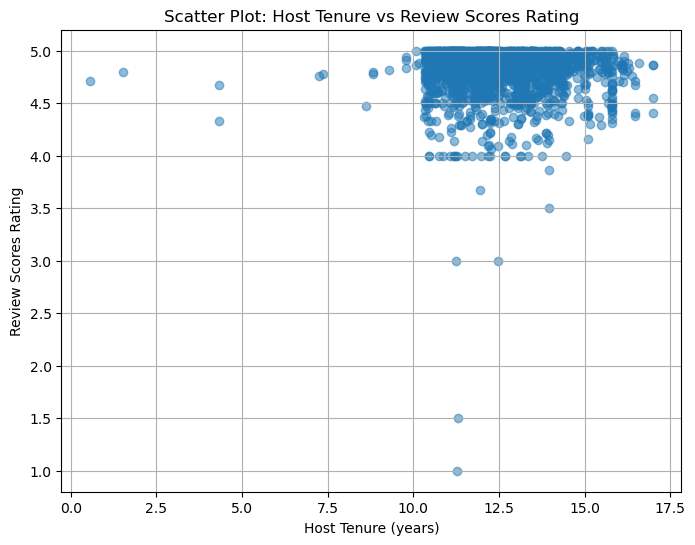

In [205]:
plt.figure(figsize=(8,6))
plt.scatter(df['host_tenure'], df['review_scores_rating'], alpha=0.5)
plt.xlabel('Host Tenure (years)')
plt.ylabel('Review Scores Rating')
plt.title('Scatter Plot: Host Tenure vs Review Scores Rating')
plt.grid(True)
plt.show()

This scatter plot tells us the same thing. The longer the host has been renting, the higher the ratings will be. However, even then, it seems that even with a lesser amount of years, while there is little data, the the ratings are still relatively high. The lowest rating is between 4 and 4.5 stars between 2.5 and 5 years. 

**4.4: Outlier checks**

I can also see that where there are much more ratings for longer tenures, there are also visibly lower ratings than what lesser years receive. Most of the reviews for the longer tenures are clumped up in the 4-5 range, but the few outliers suggest a rating of 1-3. More data evoked more outliers.

In addition, the histogram of host tenure from earlier showed that the most frequent tenure lengths were from about 10-15 years.

# Step 5: Hypothesis Testing

Restating my null and alternative hypothesis:

**Null Hypothesis**: There is no monotonic relationship between host tenure and ratings.

**Alternative Hypothesis**: There is a positive monotonic relationship between host tenure and ratings.

Since I'm attempting to check whether one variable increases as another does (Identifying a monotonic relationship), I'm going to utilize the **Spearman correlation test**.

In [206]:
valid_data = df[['host_tenure', 'review_scores_rating']].dropna() # Dropping rows with missing values before correlation.

correlation, p_value = spearmanr(valid_data['host_tenure'], valid_data['review_scores_rating'])
print(f"Spearman Rho: {correlation:.2f}, p-value: {p_value:.4f}")

Spearman Rho: -0.09, p-value: 0.0001


The p value is less than 0.05, meaning that it is statistically significant and that I should reject the null hypothesis, meaning that the null is unlikely to be true. 

Rho, being a negative number (-0.09), indicates a statistically significant but very weak negative monotonic relationship which can be caused when most data points are skewed/clustered in one area. This means that as host tenure increases, ratings slightly decrease. While the effect size is small, the significant p-value indicates this relationship cannot be by chance alone.

**LIMITATION**:
It is worth pointing out that most of the data is clustered around the 10-17.5 year range which may be a cause of the slight downward trend. Had there been more data to work with, allowing for less of a limitation, the trend may have been been different.

In [207]:
df[df['host_tenure'].between(1,10)].shape[0]

12

There is also a small sample size (<50) of hosts between the years 1 and 10, so a sensitivity analysis may lead to misleading results and should be skipped.

# Step 6: Strengthening Business Relevance 

The weak correlation between ratings and host tenure implies that a host doesn't have to be very experienced to receive good ratings, also meaning that quality is more important than a longer tenure. 

What Airbnb could do with this information is to assure newer hosts shouldn't be wary of customers' potential bias toward more experienced hosts and that what matters most is how well of a host they are overall instead of merit alone.

# Step 7: Results & Visualization

**Annotating the scatter plot with the spearman correlation results:**

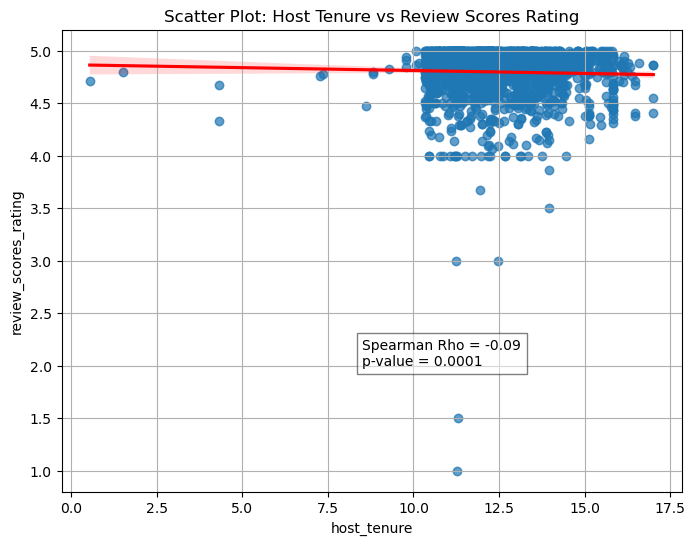

In [208]:
plt.figure(figsize=(8,6))
plt.scatter(df['host_tenure'], df['review_scores_rating'], alpha=0.5)
sns.regplot( # Using sns regplot to show regression line.
    x='host_tenure',
    y='review_scores_rating',
    data=df,
    scatter_kws={'alpha':0.4},
    line_kws={'color':'red'}
)
plt.title('Scatter Plot: Host Tenure vs Review Scores Rating')
plt.grid(True)

# Annotating scatterplot with Spearman stats.
plt.text(
    x=max(df['host_tenure'])*0.5, # Adjusting the textbox across the x-axis.
    y=min(df['review_scores_rating'])+1, # Adjusting the textbox across the y-axis.
    s=f"Spearman Rho = {correlation:.2f}\np-value = {p_value:.4f}",
    fontsize=10,
    bbox=dict(facecolor='white', alpha=0.5, edgecolor='black')
)

plt.show()

Looking very closely at the regression line, there's a slight downward trend which the negative rho value implied, again, most likely due to the bits of low reviews in the cluster of data from 10-17.5 years of host tenure.

While the p-value confirmed that there may be a chance there is a relationship between host tenure and rating, the rho value and line both show how tiny the effect size actually is.

# Step 8: Conclusion

Using Los Angeles Airbnb data, I attempted to figure out whether there was a positive monotonic relationship between host tenure and ratings or not. By cleaning the data and using it to visualize the relationship as well as performing the Spearman correlation test, I was able to take away both from the test results (Negative rho, p-value > 0.05) and from the visualizations that it was unlikely the slight downward trend/relationship was by chance, but the correlation was weak. However, as stated earlier, it was a limitation in that there was little data from host tenure that lasted from 0-10 years as opposed to 10-17.5, meaning that the results may have been different if more data were present.

Overall, my analysis revealed that due to the weak correlation, host tenure alone does not play a strong factor in whether a they can receive high ratings or not and that general host quality (Be it a newer or more experienced host) matters more.